In [131]:
import numpy as np
np.random.seed(seed=1)
import h5py
with h5py.File('../data/Assignment-1-Dataset/train_128.h5','r') as H:
    data = np.copy(H['data'])
with h5py.File('../data/Assignment-1-Dataset/train_label.h5','r') as H:
    label = np.copy(H['label'])

In [132]:
with h5py.File('../data/Assignment-1-Dataset/train_128.h5','r') as H:
    data = np.copy(H['data'])
with h5py.File('../data/Assignment-1-Dataset/train_label.h5','r') as H:
    label = np.copy(H['label'])

data = data.copy()
#data = np.c_[data, np.ones(len(data))]

g = data.copy()
epsilon = 1e-05

In [300]:
def add_constant(data):
    return np.c_[data, np.ones(len(data))]

def relu(matrix):
    # activation function that gives x if x > 0 else 0
    return np.clip(matrix, 0, None)

def leaky_relu(matrix, alpha=0.005):
    # activation function that draws on ReLU but has a slight gradient for x < 0
    matrix[matrix<0] = matrix[matrix<0] * alpha
    return matrix

def sigmoid(column):
    # activation function that returns a value between 0 and 1, good for probabilities
    return 1/(1+np.exp(-column))

def tanh(column):
    # Activation function that returns a value between -1 and 1
    # problems occurred with large negatives when applying (1 - np.exp(-column)) / (1 + np.exp(-column)) 
    # using numpy equivalent instead
    return np.tanh(column)

def softmax(layer_output):
    layer_output = layer_output / np.max(np.abs(layer_output))
    j = np.exp(layer_output) + epsilon
    j /= j.sum(axis=1).reshape(len(j),1)
    return j

def cross_entropy(output, label):
    m = len(label)
    p_out = softmax(output)
    log_func = -np.log(p_out[range(m), label])
    return np.sum(log_func) / m

def derivative_sigmoid(x):
    return np.multiply(sigmoid(x), (1-sigmoid(x)))
    
def derivative_tanh(x):
    return 1 - np.multiply(tanh(x), tanh(x))

def derivative_relu(x):
    return (x > 0) - 0.0

def derivative_leaky_relu(x, alpha=0.005):
    #returns the gradient of a leaky_relu at point x
    to_ret = grad_relu(x)
    to_ret[to_ret<=0] = alpha
    return to_ret

get_derivative = {
    'sigmoid':derivative_sigmoid,
    'tanh':derivative_tanh,
    'relu':derivative_relu,
    'leaky_relu':derivative_leaky_relu,
}

def activate(in_data, kind='relu'):
    # Apply an activation function to a node's output
    actionary = {
        'relu':relu,
        'leaky_relu':leaky_relu,
        'sigmoid':sigmoid,
        'tanh':tanh,
        'softmax':softmax
    }
    return actionary[kind](in_data)

def layer_mult(in_data, weights, bias):
    # Multiply each feature (including constant) by its weight then sum the result
    #in_data = add_constant(in_data)
    if in_data.shape[1] != weights.shape[0]:
        raise ValueError("Input matrix doesn't match weight vector: {} weights and {} features".format(
            len(weights),in_data.shape[1])
        )
    return in_data @ weights + bias
    
def layer_activate(product, activation_func='sigmoid'):
    if activation_func=='softmax':
        return softmax(product)
    else:
        return activate(product, kind=activation_func)
    
def matricise_label(label,output):
    T = np.zeros_like(output)
    T[range(len(T)),label] += 1
    return T

def get_cost(label,output):
    label = matricise_label(label,output)
    return -np.multiply(label,np.log(output)).sum()

def error_output(label,output):
    label = matricise_label(label,output)
    return (output - label)# / len(label)

def get_dout(label,output):
    label = matricise_label(label,output)
    return (output - label) / len(label)

def get_dce(output, label):
    m = len(label)
    preds = output.copy()
    preds[range(m), label] -= 1
    preds /= m
    return preds

def normalise_input(X):
    return (X - X.mean(axis=1, keepdims=True)) / X.var(axis=1, keepdims=True)

In [134]:
class Network:
    
    def __init__(self):
        self.layers = {}
        self.in_data = None
        self.n_layers = 0
        
    def set_indata(self, in_data, label):
        self.in_data = normalise_input(in_data)
        self.label = label
        self.in_features = in_data.shape[1]
        self.to_pass = self.in_data
    
    def assign_layer(self, n_nodes, activation, n_inputs):
        self.layers[self.n_layers] = Layer(n_nodes, activation, n_inputs)
        self.n_layers += 1
        
    def feed_forward(self):
        self.outputs_by_layer = []
        data_in = self.in_data.copy()
        for ilayer in self.layers.values():
            #print(ilayer.activation)
            self.ilayer = ilayer
            data_in = ilayer.get_layer_output(data_in)
            self.outputs_by_layer.append(data_in.copy())
        self.output = data_in.reshape(data_in.shape[:2])
        return self.outputs_by_layer
    
    def score_network(self):
        self.feed_forward()
        self.prediction = np.argmax(self.output, axis=1).reshape(len(self.label))
        self.error = get_cost(self.label, self.output)
        return self.error
    
    def backpropagate(self):
        self.dout = get_dce(self.output,self.label)
        dout = self.dout
        for iteration in range(len(self.layers),0,-1):
            i = iteration - 1
            ilayer = self.layers[i]
            if i != max(self.layers.keys()):
                dout = ilayer.get_afunc_derivative(dout)
            dout = ilayer.get_product_derivative(dout)
            self.layers[i].dout = dout
            
    def get_updates(self, train_rate=0.05, momentum=0.9):
        i=0
        for ilayer in self.layers.values():
            i+=1
            #print(i, ilayer.weights.shape, ilayer.grads_w.shape)
            ilayer.w_update = (momentum*ilayer.w_update) + (ilayer.grads_w * train_rate)
            ilayer.b_update = (momentum*ilayer.b_update) + (ilayer.grads_b * train_rate)
        
    def update_weights(self, train_rate=0.05, wnorm=False):
        i=0
        for ilayer in self.layers.values():
            i+=1
            #print(i, ilayer.weights.shape, ilayer.grads_w.shape)
            ilayer.weights -= ilayer.w_update
            ilayer.bias -= ilayer.b_update

    def train(self, iters, train_rate = 0.05):
        self.old_error = get_cost(self.label, self.output)
        self.last_update = 0
        for i in range(iters):
            self.backpropagate()
            self.get_updates()
            self.update_weights()
            self.score_network()
        self.new_error = get_cost(self.label, self.output)
        print(self.new_error - self.old_error)
        
        
    def get_mangrads(self, epsilon=1e-6):
        error = self.score_network()
        for ilayer in self.layers.values():
            ilayer.mangrads = np.zeros_like(ilayer.weights)
            for irow in range(len(ilayer.weights)):
                for icol in range(len(ilayer.weights[irow])):
                    ilayer.weights[irow,icol] += epsilon
                    new_error = self.score_network()
                    ilayer.mangrads[irow,icol] += (new_error - error)/epsilon
                    ilayer.weights[irow,icol] -= epsilon
        error = self.score_network

In [371]:
class Layer:
    
    def __init__(self, n_nodes, activation, n_inputs):
        self.activation = activation
        afunc = self.activation
        self.weights = np.random.random((n_inputs,n_nodes))
        self.bias = np.random.randn(n_nodes)
        self.w_update = 0
        self.b_update = 0

    def get_layer_output(self, df_in, batch_norm=True):
        self.input = df_in
        self.product = layer_mult(df_in, self.weights, self.bias)
        self.output = layer_activate(self.product, activation_func=self.activation)
        return self.output
    
    def get_afunc_derivative(self, d_backpass):
        self.afunc_d_backpass = d_backpass
        derivative = get_derivative[self.activation]
        to_backpass = derivative(self.product) * d_backpass
        return to_backpass
    
    def get_product_derivative(self, d_backpass):
        self.prod_d_backpass = d_backpass
        self.grads_w = self.input.T @ d_backpass
        self.grads_b = np.sum(d_backpass, axis=0)
        to_backpass = d_backpass @ self.weights.T
        return to_backpass
        

In [446]:
%%time
l = 20

np.random.seed(22)
#g = np.random.random((5,20))
#label = np.random.randint(0,10,5)

t = Network()
t.set_indata(g[:l], label[:l])


t.assign_layer(50,'relu', 128)
#t.assign_layer(500,'relu', 500)
#t.assign_layer(25,'leaky_relu', 128)
#t.assign_layer(12,'sigmoid',15)
t.assign_layer(10,'softmax',50)

t.score_network()
t.backpropagate()
t.get_mangrads()
print(t.error)

45.7215690542
CPU times: user 914 ms, sys: 14 ms, total: 928 ms
Wall time: 936 ms


In [447]:
t.train(2)
t.backpropagate()
t.get_mangrads()

-0.369290396147


In [436]:
t.layers[1].bias

array([ 0.44255448, -1.23832373, -1.2226584 , -0.94936919, -0.39642234,
       -0.56284284,  1.49926527,  0.68035124, -0.51152225,  0.79505286])

In [433]:
t.layers[1].weights[:,i]

array([ 0.40106871,  0.85264812,  0.77478236,  0.16889951,  0.63980614,
        0.14688109,  0.08550399,  0.53817073,  0.67907216,  0.46724809,
        0.66056552,  0.20699599,  1.00957969,  0.25615731,  0.50542199,
        0.00677057,  1.08459404,  1.16289363,  0.8982525 ,  0.69582325,
        0.04130751,  0.20201388,  0.94421837,  0.28284747,  0.77002148,
        1.01285235,  0.66724203,  0.18952908,  1.02683108,  0.09903319,
        0.44750931,  0.58470446,  0.03740661,  0.30840736,  0.15752755,
        0.19767272,  0.38873453,  0.95162073,  0.28833995,  0.15179868,
        0.8633189 ,  0.65469904,  0.93438511,  0.507066  ,  0.37348023,
        0.7852457 ,  0.87352628,  1.14534057,  0.0364023 ,  0.2851143 ])

In [453]:
i = 10
l = 0

t.layers[l].grads_w[:,i] / t.layers[l].mangrads[:,i] 

array([  0.23058347,   0.70436555,   0.7203577 ,   1.55792399,
         0.75810187,   0.80324604,   1.06511401,   0.46357555,
         0.77538262,   0.68834938,   0.79052761,   0.79814111,
         0.53244922,  -0.09353118,   6.0066462 ,  -0.14954872,
         0.31949622,   0.69164938,   0.69099882,   1.29098563,
         0.61651037,   0.08507189,   4.54662562,   2.13870053,
         3.79766041,   0.44510898,   0.50976726,  -0.76614313,
         2.00274038,   1.55178067,  -0.7159276 ,  -0.1928274 ,
         0.07500734,   2.13992377,   0.50537193,   0.04944008,
         0.36438618,   0.60936273,  12.34002887,   0.08579525,
         0.77885106,   1.36493806,  -5.21547499,   0.43181826,
         0.16158447,   1.94331154,   0.51487128,   0.49436772,
         0.38731017,   0.3613523 ,   0.43755643,   1.13515851,
         0.49121807,   3.90451738,   1.53026137,  -0.09344412,
         0.2059406 ,   0.89973067,   0.61003904,   0.17820709,
         0.12046772,   1.13977501,   0.79868242,   1.43

In [407]:
np.allclose(t.layers[1].mangrads[:,i], t.layers[1].grads_w[:,i])

False

In [375]:
t.train(500)

0.0


In [376]:
t.prediction

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [346]:
get_cost?

In [362]:
test_output = t.output.copy()
old_error = get_cost(t.label, test_output)
output_grads = []
for i in range(test_output.shape[1]):
    test_output[:,i] += epsilon
    output_grads.append(get_cost(t.label, test_output)- old_error) 
    test_output[:,i] -= epsilon

In [367]:
t.layers[2].grads_w

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.

In [370]:
t.layers[1].weights[0]

array([ 0.30366002, -0.40967897,  0.5750902 , -0.19845714,  0.38912031,
        0.10144846,  0.80659926, -0.08950954,  0.39371617,  1.23882716,
       -0.32876484,  0.38711611,  0.68372851,  0.06480703,  0.54310119,
        0.806761  ,  0.1090789 ,  0.97862672,  0.58724098, -0.42613699,
        0.52227834,  1.74019081,  0.77556802,  0.71225036, -0.28961528,
        0.67465027,  0.1703845 ,  0.39727038, -0.09934754,  0.40173967,
        0.47005709,  1.38184874,  1.02877867, -0.45658902,  0.77552531,
       -0.29338505,  0.02078638,  0.33103971,  0.55108329, -0.21489282,
        0.2821035 ,  0.78199794, -0.31781169,  0.28965301, -0.4339738 ,
        0.30249869, -0.18009528,  0.69198284,  0.93249157,  0.03985033])

In [368]:
t.layers[1].output

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [363]:
output_grads

[-0.0019999166713091654,
 -0.0019999230808593893,
 -0.0019998888971031192,
 -0.0019998823621563133,
 -0.0019998888971599627,
 -0.0019999000066945882,
 -0.0019999047679561954,
 -0.0019999047679561954,
 -0.0019998750104264218,
 -0.0019998947441877135]

In [324]:
t.get_mangrads()

In [326]:
t.layers[0].mangrads[0], t.layers[0].grads_w[0]

(array([ -1.65982783e-05,  -3.13775672e-05,   2.54090082e-05,
         -2.13731255e-05,   3.56408236e-05]),
 array([-0.00017458, -0.00032883,  0.00026597, -0.00022484,  0.00037298]))

In [307]:
test_output = t.output

In [305]:
cross_entropy(test_output, [0,9])

2.2255334534459408

In [301]:
get_dout(t.label,t.output)

array([[ 0.05493821,  0.04016666,  0.06442238,  0.04456636,  0.04124994,
         0.06096364,  0.04847955,  0.04757132,  0.041621  , -0.44397905],
       [-0.44504614,  0.04016599,  0.06445408,  0.04458198,  0.04124244,
         0.06092663,  0.04844003,  0.04757531,  0.04160851,  0.05605117]])

In [309]:
get_dce(t.output,t.label)

array([[ 0.0574294 ,  0.03963756,  0.0636023 ,  0.04399186,  0.04071347,
         0.06016038,  0.04788276,  0.04696284,  0.04105631, -0.44143688],
       [-0.4425494 ,  0.03963593,  0.06363164,  0.04400608,  0.04070498,
         0.06012106,  0.04784188,  0.04696538,  0.0410427 ,  0.05859974]])

In [257]:
t.layers[2].get_product_derivative(err)

array([[-0.10630164, -0.344087  , -0.01732137, -0.03571993,  0.10211899,
         0.10618585, -0.18991442,  0.10129816,  0.02949733, -0.06896471],
       [-0.08095868,  0.07616902, -0.18889889,  0.18843297,  0.10181084,
         0.12785157, -0.10830791, -0.08959983, -0.19846185, -0.24157868]])

In [258]:
ilayer = t.layers[2]

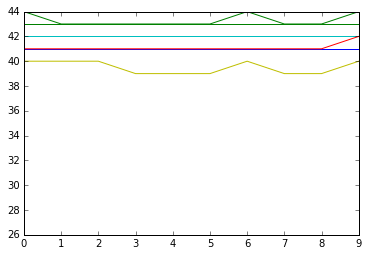

In [266]:
plt.plot(np.round(ilayer.grads_w / ilayer.mangrads, 0))

In [259]:
ilayer.grads_w

array([[-0.12542892,  0.02714585,  0.03955924,  0.02906723,  0.02760448,
         0.03747238,  0.03087342,  0.03045172,  0.02776278, -0.12450817],
       [-0.25764486,  0.0557195 ,  0.08119922,  0.05966332,  0.05666088,
         0.0769157 ,  0.0633707 ,  0.06250513,  0.05698581, -0.2553754 ],
       [-0.25399041,  0.05488224,  0.07997911,  0.05876681,  0.05580948,
         0.07575992,  0.06241846,  0.0615659 ,  0.05612952, -0.25132102],
       [-0.27642081,  0.05975436,  0.08707916,  0.06398377,  0.06076391,
         0.08248544,  0.0679596 ,  0.06703135,  0.06111236, -0.27374912],
       [-0.24678901,  0.05343344,  0.07786776,  0.05721545,  0.05433621,
         0.07376002,  0.06077074,  0.05994066,  0.0546478 , -0.24518308],
       [-0.09687994,  0.0209285 ,  0.03049881,  0.02240982,  0.02128209,
         0.02888988,  0.02380232,  0.02347721,  0.02140413, -0.09581281],
       [-0.17155859,  0.03708756,  0.05404716,  0.03971261,  0.03771415,
         0.05119599,  0.04218028,  0.04160415

In [292]:
get_cost(t.label, t.output)

4.396996581048926

In [293]:
cross_entropy(t.output, t.label)

2.2256464566283061

In [291]:
t.layers[2].grads_w

array([[-0.12542892,  0.02714585,  0.03955924,  0.02906723,  0.02760448,
         0.03747238,  0.03087342,  0.03045172,  0.02776278, -0.12450817],
       [-0.25764486,  0.0557195 ,  0.08119922,  0.05966332,  0.05666088,
         0.0769157 ,  0.0633707 ,  0.06250513,  0.05698581, -0.2553754 ],
       [-0.25399041,  0.05488224,  0.07997911,  0.05876681,  0.05580948,
         0.07575992,  0.06241846,  0.0615659 ,  0.05612952, -0.25132102],
       [-0.27642081,  0.05975436,  0.08707916,  0.06398377,  0.06076391,
         0.08248544,  0.0679596 ,  0.06703135,  0.06111236, -0.27374912],
       [-0.24678901,  0.05343344,  0.07786776,  0.05721545,  0.05433621,
         0.07376002,  0.06077074,  0.05994066,  0.0546478 , -0.24518308],
       [-0.09687994,  0.0209285 ,  0.03049881,  0.02240982,  0.02128209,
         0.02888988,  0.02380232,  0.02347721,  0.02140413, -0.09581281],
       [-0.17155859,  0.03708756,  0.05404716,  0.03971261,  0.03771415,
         0.05119599,  0.04218028,  0.04160415

In [252]:
t.layers[1].get_product_derivative(t.layers[1].get_afunc_derivative(t.layers[2].get_product_derivative(err)))

array([[-0.08414356, -0.06503721, -0.09954917, -0.08193484, -0.05100025],
       [-0.02819732, -0.01448396, -0.00639131, -0.04403811, -0.00909677]])

In [ ]:
t.layers[2].get_afunc_derivative

In [ ]:
t.layers[2].get_afunc_derivative

In [ ]:
t.layers[2].get_afunc_gradient

In [210]:
t.layers[2].weights[:,9]

array([ 0.43992836,  0.49867195,  0.83450629,  0.21085033,  0.91344482])

In [212]:
t.layers[2].weights[:,9]

array([ 0.46101685,  0.56115155,  0.86847486,  0.24188919,  0.95429186])

In [194]:
softmax(t.output)

array([[ 0.07071164,  0.12706232,  0.08628238,  0.12572084,  0.09722865,
         0.08681074,  0.08294507,  0.14591024,  0.0800286 ,  0.09729953],
       [ 0.07070579,  0.12708018,  0.08628507,  0.12568601,  0.0972264 ,
         0.08681273,  0.08295283,  0.14591973,  0.08003525,  0.09729601]])

In [192]:
t.output

array([[ 0.04618267,  0.14440872,  0.07953804,  0.14262983,  0.09955642,
         0.08056125,  0.07292669,  0.16759037,  0.06692744,  0.09967856],
       [ 0.04616851,  0.14443199,  0.07954299,  0.1425831 ,  0.09955227,
         0.0805648 ,  0.07294207,  0.16760098,  0.06694108,  0.09967222]])

In [159]:
(ilayer.grads_w*100).astype(int)

array([[-2,  2,  0,  0,  0, -1,  0,  2,  1,  0],
       [-8,  6, -1,  0,  0, -4, -1,  5,  3,  0],
       [-4,  3,  0,  0,  0, -2,  0,  3,  1,  0],
       [-4,  3,  0,  0,  0, -2,  0,  3,  1,  0],
       [-5,  3,  0,  0,  0, -3,  0,  3,  2,  0]])

In [154]:
(ilayer.mangrads*10000).astype(int)

array([[-1,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [-3,  2,  0,  0,  0, -1,  0, -2,  0,  0],
       [-1,  1,  0,  0,  0,  0,  0, -1,  0,  0],
       [-1,  1,  0,  0,  0,  0,  0, -1,  0,  0],
       [-2,  1,  0,  0,  0, -1,  0, -1,  0,  0]])

In [165]:
import matplotlib.pyplot as plt
%matplotlib inline

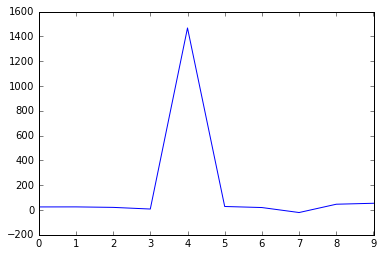

In [187]:
plt.plot(ilayer.grads_w[0] / ilayer.mangrads[0])

In [181]:
ilayer.mangrads

array([[ -1.11203274e-03,   8.20994772e-04,  -1.92853705e-04,
          2.19515739e-04,  -5.26995114e-07,  -5.75156145e-04,
         -2.56395710e-04,  -9.95090149e-04,   2.65378275e-04,
         -2.16541507e-05],
       [ -3.28221431e-03,   2.42779175e-03,  -5.76243719e-04,
          6.53346849e-04,  -3.11298209e-06,  -1.69473538e-03,
         -7.63195507e-04,  -2.92144217e-03,   7.83002052e-04,
         -6.24029994e-05],
       [ -1.78109980e-03,   1.31674688e-03,  -3.12185611e-04,
          3.54781426e-04,  -2.89496205e-06,  -9.20391374e-04,
         -4.13411194e-04,  -1.58360422e-03,   4.24599245e-04,
         -3.21163651e-05],
       [ -1.66509642e-03,   1.22767266e-03,  -2.91213970e-04,
          3.29622024e-04,  -2.17095786e-06,  -8.56296895e-04,
         -3.85198456e-04,  -1.48805526e-03,   3.97686800e-04,
         -3.06991654e-05],
       [ -2.14258503e-03,   1.58286984e-03,  -3.73642700e-04,
          4.25020852e-04,  -1.88093985e-06,  -1.10800330e-03,
         -4.95405467e-04

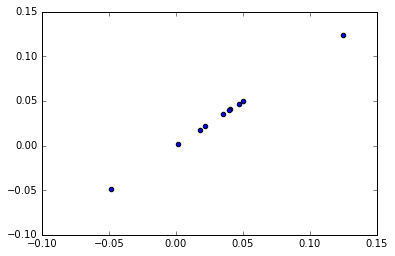

In [180]:
plt.scatter((ilayer.mangrads / ilayer.grads_w )[1],(ilayer.mangrads / ilayer.grads_w )[2])

In [141]:
lnum,i,j = 2,4,1
ilayer = t.layers[lnum]
print(ilayer.grads_w[i,j], #Check backprop grads
      ilayer.mangrads[i,j], # Check manual grads
     )

0.039728623902 0.0015828698352


In [124]:
def fc_forward(X, W, b):
    out = X @ W + b
    cache = (W, X)
    return out, cache

def fc_backward(dout, cache):
    W, h = cache
    dW = h.T @ dout
    db = np.sum(dout, axis=0)
    dX = dout @ W.T
    return dX, dW, db

def relu_backward(dout, cache):
    dX = dout.copy()
    dX[cache <= 0] = 0
    return dX

def relu_forward(X):
    out = np.maximum(X, 0)
    cache = X
    print(len(out),len(cache))
    return out, cache

In [43]:
np.random.seed(1)
#cache is W and h1
data = np.random.random((3,5))-0.5 # instances # features
weights = np.random.random((5,4)) # features X nodes
bias = np.array([range(4)])/10 # nodes_bias
#dout is error passed back
dout = np.random.random((3,4))

In [15]:
out, mcache = fc_forward(data, weights, bias)
out, acache = relu_forward(out)
fc_backward(relu_backward(dout, acache),mcache)[0]
#relu_backward(dout, acache)
#out
fc_backward(relu_backward(dout, acache), mcache)[0]

3 3


array([[ 0.00256744,  0.00573199,  0.00155531,  0.00179859,  0.01265324],
       [ 0.03937067,  0.08789793,  0.02385014,  0.02758078,  0.19403278],
       [ 0.3777885 ,  0.71845389,  0.47795932,  0.48267183,  0.86743771]])

In [16]:
z = Layer(5,'relu',6)
z.input = data
z.weights = weights
z.bias = bias

#prod = data * weights
z.get_layer_output(data)
#z.get_product_derivative(z.get_afunc_derivative(dout))
z.get_product_derivative(z.get_afunc_derivative(dout))# == fc_backward(relu_backward(dout, acache), mcache)[0]

array([[ 0.00256744,  0.00573199,  0.00155531,  0.00179859,  0.01265324],
       [ 0.03937067,  0.08789793,  0.02385014,  0.02758078,  0.19403278],
       [ 0.3777885 ,  0.71845389,  0.47795932,  0.48267183,  0.86743771]])

In [80]:
np.random.randint?

In [97]:

l = 50

np.random.seed(22)
#g = np.random.random((5,20))
#label = np.random.randint(0,10,5)

t = Network()
t.set_indata(g[:l], label[:l])

#t.assign_layer(10,'relu', 128)
#t.assign_layer(25,'leaky_relu', 128)
t.assign_layer(500,'relu', 128)
t.assign_layer(500,'relu', 500)
#t.assign_layer(25,'leaky_relu', 128)
#t.assign_layer(12,'sigmoid',15)
t.assign_layer(10,'softmax',500)

t.score_network()
t.backpropagate()
#t.get_mangrads()
print(t.error)

0.230274237502


In [84]:
g

array([[ 0.20846054,  0.48168106,  0.42053804,  0.859182  ,  0.17116155,
         0.33886396,  0.27053283,  0.69104135,  0.22040452,  0.81195092,
         0.01052687,  0.5612037 ,  0.81372619,  0.7451003 ,  0.18911136,
         0.00614087,  0.77204387,  0.95783217,  0.70193788,  0.29757827],
       [ 0.76799274,  0.68821832,  0.38718348,  0.61520583,  0.42755524,
         0.58428964,  0.70263552,  0.11189517,  0.92326993,  0.98888627,
         0.67741077,  0.79516478,  0.02907635,  0.17775907,  0.87492775,
         0.74493208,  0.50809016,  0.1283339 ,  0.48428424,  0.51577349],
       [ 0.31126466,  0.04566154,  0.43768066,  0.09588461,  0.04521011,
         0.68482872,  0.84919075,  0.12520718,  0.12906401,  0.47306   ,
         0.19755851,  0.78162275,  0.60741386,  0.44350009,  0.98202911,
         0.70895541,  0.21873042,  0.1674883 ,  0.53876547,  0.31342079],
       [ 0.911537  ,  0.08625568,  0.31407403,  0.21913736,  0.73666623,
         0.82854036,  0.74456446,  0.17753704,  

In [85]:
label

array([6, 2, 8, 5, 0])

In [76]:
t.train(200)

-0.000483760478827


In [77]:
t.error

0.22459270449537813

In [78]:
t.prediction

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0])

0.242347686758


In [121]:
t.layers[2].

'softmax'

In [126]:
t.train(5)

-0.000818379860695


-0.0022996477241 -1.88093984832e-06


In [12]:
ilayer.grads_w  / ilayer.mangrads

/Users/jmacdonald/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


array([[  3.45854539e+03,   3.66125694e+04,   1.75276218e+04,
         -8.14334351e+03,  -1.85313746e+04,   6.31728022e+04,
         -3.17947081e+04,   1.07029926e+03,   1.34963327e+04,
          2.09006126e+04,   3.90045916e+04,   9.38328485e+03,
          2.76267620e+04,   9.16341746e+03,   2.65577597e+05,
          7.76956170e+03,   1.43149895e+05,   4.96174681e+04,
          4.45936910e+04,   3.34384791e+04],
       [ -1.19008716e+03,   3.67736664e+04,   1.74985351e+04,
         -6.05461983e+03,  -3.27176108e+03,   7.53540800e+04,
         -2.59184976e+04,   1.36420584e+03,   1.44430872e+04,
          2.09703718e+04,   3.95837059e+04,   3.63102697e+03,
          2.75751024e+04,   6.27534463e+03,   5.68621058e+05,
          9.78706088e+03,   1.30202232e+05,   4.87287860e+04,
          4.65642112e+04,   3.35843055e+04],
       [             nan,              nan,              nan,
                     nan,              nan,              nan,
                     nan,              nan

In [918]:
matricise_label(label[:l], t.output)

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.

In [830]:
ilayer.w_update

0

In [815]:
ilayer.grads_w

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [-0.04336676,  0.00976251,  0.00808357, -0.01540056,  0.01050987,
         0.00561242,  0.00319403,  0.00983543,  0.0049072 ,  0.00686229],
       [-0.21456937,  0.0480537 ,  0.03978873, -0.06501779,  0.05170294,
         0.02761138,  0.01572486,  0.04837764,  0.02414765,  0.02418027]])

In [816]:
ilayer.weights

array([[ 0.01038004,  0.32742784,  0.82849109,  0.11259759,  0.02469574,
         0.81435353,  0.24890527,  0.2491966 ,  0.1582368 ,  0.27605595],
       [ 0.42871035,  0.25842181,  0.36694704,  0.34929559,  0.33303578,
         0.3033672 ,  0.31512729,  0.27022518,  0.90029462,  0.9669742 ],
       [ 0.89669855,  0.37327538,  0.64827922,  0.31144182,  0.8099721 ,
         0.8047729 ,  0.79441769,  0.11143517,  0.81159814,  0.77955234],
       [ 0.89068014,  0.32116235,  0.10612497,  0.16327289,  0.6714358 ,
         0.71343323,  0.23682575,  0.80445612,  0.91766982,  0.98366129],
       [ 1.02795787,  0.50900478,  0.69436502,  0.08583992,  0.8937227 ,
         0.80964578,  0.35681598,  0.96877689,  0.38254362,  0.01262672]])

In [782]:
"{:.2f}%".format((t.prediction == label[:l]).mean()*100)

'10.00%'

In [790]:
set(t.prediction)

{8}

In [386]:
list(zip(t.prediction, label[:100]))

[(7, 9),
 (7, 0),
 (7, 0),
 (7, 3),
 (7, 0),
 (7, 2),
 (7, 7),
 (7, 2),
 (7, 5),
 (7, 5),
 (7, 0),
 (7, 9),
 (7, 5),
 (7, 5),
 (7, 7),
 (7, 9),
 (7, 1),
 (7, 0),
 (7, 6),
 (7, 4),
 (7, 3),
 (7, 1),
 (7, 4),
 (7, 8),
 (7, 4),
 (7, 3),
 (7, 0),
 (7, 2),
 (7, 4),
 (7, 4),
 (7, 5),
 (7, 3),
 (7, 6),
 (7, 6),
 (7, 0),
 (7, 8),
 (7, 5),
 (7, 2),
 (7, 1),
 (7, 6),
 (7, 6),
 (7, 7),
 (7, 9),
 (7, 5),
 (7, 9),
 (7, 2),
 (7, 7),
 (7, 3),
 (7, 0),
 (7, 3),
 (7, 3),
 (7, 3),
 (7, 7),
 (7, 2),
 (7, 2),
 (7, 6),
 (7, 6),
 (7, 8),
 (7, 3),
 (7, 3),
 (7, 5),
 (7, 0),
 (7, 5),
 (7, 5),
 (7, 0),
 (7, 2),
 (7, 0),
 (7, 0),
 (7, 4),
 (7, 1),
 (7, 3),
 (7, 1),
 (7, 6),
 (7, 3),
 (7, 1),
 (7, 4),
 (7, 4),
 (7, 6),
 (7, 1),
 (7, 9),
 (7, 1),
 (7, 3),
 (7, 5),
 (7, 7),
 (7, 9),
 (7, 7),
 (7, 1),
 (7, 7),
 (7, 9),
 (7, 9),
 (7, 9),
 (7, 3),
 (7, 2),
 (7, 9),
 (7, 3),
 (7, 6),
 (7, 4),
 (7, 1),
 (7, 1),
 (7, 8)]